# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with [OpenAI Gym's Pendulum v-0 environment](https://gym.openai.com/envs/Pendulum-v0/).

The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. This environment is unsolved, so we will just try to make progress and learn.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
from DDPG_Agent import DDPG_Agent

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

In [2]:
env = gym.make('Pendulum-v0')
env.seed(10)
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

print('Action Size:', action_size)
print('Action High:', env.action_space.high)
print('Action Low:', env.action_space.low)
print('State Size:', state_size)
print('State High:', env.observation_space.high)
print('State Low:', env.observation_space.low)

Action Size: 1
Action High: [2.]
Action Low: [-2.]
State Size: 3
State High: [1. 1. 8.]
State Low: [-1. -1. -8.]


In [3]:
agent = DDPG_Agent(state_size=state_size, action_size=action_size, random_seed=10)

### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [4]:
from tqdm.notebook import tqdm

def ddpg(n_episodes=1000, max_t=300):
    
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    steps = -np.Inf
    
    for i_episode in tqdm(range(1, n_episodes+1)):
        
        state = env.reset()
        agent.reset()
        score = 0
        
        for t in range(max_t):
            
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
        
            if done:
                steps = t
                break
                
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tSteps: {:.2f}'.format(i_episode, np.mean(scores_deque), score, steps), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque) == 300.00:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            return scores 
    return scores

Episode 100	Average Score: -1167.97	Score: -1088.94	Steps: 199.00
Episode 200	Average Score: -769.27	Score: -249.75	Steps: 199.0000
Episode 300	Average Score: -439.18	Score: -242.23	Steps: 199.000
Episode 400	Average Score: -378.74	Score: -250.34	Steps: 199.000
Episode 500	Average Score: -687.74	Score: -362.25	Steps: 199.000
Episode 600	Average Score: -532.00	Score: -1533.40	Steps: 199.00
Episode 700	Average Score: -467.25	Score: -362.16	Steps: 199.000
Episode 800	Average Score: -403.92	Score: -0.34	Steps: 199.00000
Episode 900	Average Score: -478.88	Score: -850.43	Steps: 199.000
Episode 1000	Average Score: -624.30	Score: -867.90	Steps: 199.00



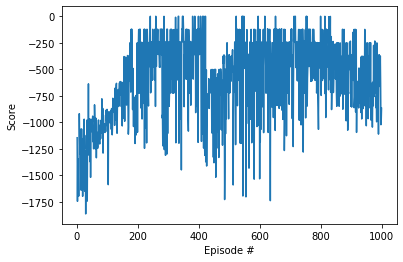

In [5]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [6]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

state = env.reset()
agent.reset()
score = []

while True:
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    score.append(reward)
    state = next_state
    if done:
        break

print(np.sum(score))        
env.close()

-758.6467811253642
